<a href="https://colab.research.google.com/github/MinkyuRamen/KubigFinancialProject/blob/main/ky/FINRL_Application_KY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINRL Application

- ETF 유니버스 데이터 사용
- 예측 데이터 어떻게 사용할지 -> 예측 결과를 indicator로 줄 수 있는가.? 실험 필요할듯. indicator가 state의 형태로 정보를 입력받는 것으로 봐서는 가능할 것 같긴함.
- 포트폴리오 구성 방법 논의 필요
- 최고의 Baseline? 다양한 baseline 시도가 필요하나. indicator 에서 설정을 바꿔가면서 해야함

### Package Install

In [1]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✨🍰✨ Everything looks OK!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-9ieyy26v
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-9ieyy26v
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 7414adb012b554f7c684d4615830dc5c31a094d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-0sd6wy5w/elegantrl_3

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


### Create Folders

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [4]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [5]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-05'

In [7]:
tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

In [8]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30213, 8)


In [10]:
df

,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.488930,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,38.080166,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.385946,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.880186,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.150225,8449400,XLK,0
...,...,...,...,...,...,...,...,...
30208,2023-05-04,147.660004,148.539993,146.929993,147.539993,5430500,XLK,3
30209,2023-05-04,76.739998,76.860001,76.220001,76.470001,11682600,XLP,3
30210,2023-05-04,68.190002,68.860001,67.550003,68.589996,14631100,XLU,3
30211,2023-05-04,132.899994,132.979996,131.839996,132.399994,9625300,XLV,3


In [11]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.488930,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,38.080166,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.385946,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.880186,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.150225,8449400,XLK,0


### ETF 도메인 별로 최적의 하이퍼 파라미터 튜닝을 진행해보자

In [13]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

INDICATORS는 FINRL 기본 베이스라인으로 해도 괜찮을 것 같음

https://github.com/jealous/stockstats


- change (in percent)
- delta
- permutation (zero-based)
- log return
- max in range
- min in range
- middle = (close + high + low) / 3
- compare: le, ge, lt, gt, eq, ne
- count: both backward(c) and forward(fc)
- cross: including upward cross and downward cross
- SMA: Simple Moving Average
- EMA: Exponential Moving Average
- MSTD: Moving Standard Deviation
- MVAR: Moving Variance
- RSV: Raw Stochastic Value
- RSI: Relative Strength Index
- KDJ: Stochastic Oscillator
- Bolling: Bollinger Band
- MACD: Moving Average Convergence Divergence
- CR: Energy Index (Intermediate Willingness Index)
- WR: Williams Overbought/Oversold index
- CCI: Commodity Channel Index
- TR: True Range
- ATR: Average True Range
- DMA: Different of Moving Average (10, 50)
- DMI: Directional Moving Index, including
- +DI: Positive Directional Indicator
- -DI: Negative Directional Indicator
- ADX: Average Directional Movement Index
- ADXR: Smoothed Moving Average of ADX
- TRIX: Triple Exponential Moving Average
- TEMA: Another Triple Exponential Moving Average
- VR: Volume Variation Index
- MFI: Money Flow Index
- VWMA: Volume Weighted Moving Average
- CHOP: Choppiness Index
- KAMA: Kaufman's Adaptive Moving Average
- PPO: Percentage Price Oscillator
- StochRSI: Stochastic RSI
- WT: LazyBear's Wave Trend
- Supertrend: with the Upper Band and Lower Band

In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3356, 8)
Successfully added vix
Successfully added turbulence index


In [14]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,33.580002,34.020000,33.450001,25.488930,7567500,XLB,0,0.000000,25.646696,25.413582,100.000000,66.666667,100.000000,25.488930,25.488930,20.040001,0.000000
1,2010-01-04,57.919998,58.810001,57.790001,38.080166,16928400,XLE,0,0.000000,25.646696,25.413582,100.000000,66.666667,100.000000,38.080166,38.080166,20.040001,0.000000
2,2010-01-04,11.795288,11.965881,11.770918,9.385946,92942347,XLF,0,0.000000,25.646696,25.413582,100.000000,66.666667,100.000000,9.385946,9.385946,20.040001,0.000000
3,2010-01-04,28.090000,28.320000,27.959999,21.880186,7471500,XLI,0,0.000000,25.646696,25.413582,100.000000,66.666667,100.000000,21.880186,21.880186,20.040001,0.000000
4,2010-01-04,23.139999,23.290001,23.100000,19.150225,8449400,XLK,0,0.000000,25.646696,25.413582,100.000000,66.666667,100.000000,19.150225,19.150225,20.040001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30199,2023-05-03,149.690002,150.660004,148.179993,148.250000,5815100,XLK,2,1.103573,151.661404,145.211595,55.182961,46.413505,6.225843,148.009000,143.818154,18.340000,4.220014
30200,2023-05-03,77.059998,77.379997,76.639999,76.660004,11656600,XLP,2,0.881914,77.736710,74.605290,58.998054,93.513436,22.508083,75.326333,73.789483,18.340000,4.220014
30201,2023-05-03,68.639999,69.050003,67.989998,68.070000,11857200,XLU,2,0.322353,70.369304,68.133697,50.161289,8.082351,8.132944,68.236667,67.193014,18.340000,4.220014
30202,2023-05-03,134.259995,134.899994,133.270004,133.460007,8961500,XLV,2,0.919474,135.482523,132.061479,53.906929,54.079518,6.687990,131.858668,130.130313,18.340000,4.220014


In [17]:
list_ticker = processed["tic"].unique().tolist() #ticker 리스트 불러오기
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str)) #전체 데이터 날짜 날짜 리스트
combination = list(itertools.product(list_date,list_ticker)) #date, ticker 의 combination

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left") #date, tic combination 기준으로 우측에 해당되는 정보들 정리
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.488930,7567500.0,0.0,0.000000,25.646696,25.413582,100.000000,66.666667,100.000000,25.488930,25.488930,20.040001,0.000000
1,2010-01-04,XLE,57.919998,58.810001,57.790001,38.080166,16928400.0,0.0,0.000000,25.646696,25.413582,100.000000,66.666667,100.000000,38.080166,38.080166,20.040001,0.000000
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.385946,92942347.0,0.0,0.000000,25.646696,25.413582,100.000000,66.666667,100.000000,9.385946,9.385946,20.040001,0.000000
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.880186,7471500.0,0.0,0.000000,25.646696,25.413582,100.000000,66.666667,100.000000,21.880186,21.880186,20.040001,0.000000
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.150225,8449400.0,0.0,0.000000,25.646696,25.413582,100.000000,66.666667,100.000000,19.150225,19.150225,20.040001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43807,2023-05-03,XLK,149.690002,150.660004,148.179993,148.250000,5815100.0,2.0,1.103573,151.661404,145.211595,55.182961,46.413505,6.225843,148.009000,143.818154,18.340000,4.220014
43808,2023-05-03,XLP,77.059998,77.379997,76.639999,76.660004,11656600.0,2.0,0.881914,77.736710,74.605290,58.998054,93.513436,22.508083,75.326333,73.789483,18.340000,4.220014
43809,2023-05-03,XLU,68.639999,69.050003,67.989998,68.070000,11857200.0,2.0,0.322353,70.369304,68.133697,50.161289,8.082351,8.132944,68.236667,67.193014,18.340000,4.220014
43810,2023-05-03,XLV,134.259995,134.899994,133.270004,133.460007,8961500.0,2.0,0.919474,135.482523,132.061479,53.906929,54.079518,6.687990,131.858668,130.130313,18.340000,4.220014


In [18]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.488930,7567500.0,0.0,0.000000,25.646696,25.413582,100.0,66.666667,100.0,25.488930,25.488930,20.040001,0.0
1,2010-01-04,XLE,57.919998,58.810001,57.790001,38.080166,16928400.0,0.0,0.000000,25.646696,25.413582,100.0,66.666667,100.0,38.080166,38.080166,20.040001,0.0
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.385946,92942347.0,0.0,0.000000,25.646696,25.413582,100.0,66.666667,100.0,9.385946,9.385946,20.040001,0.0
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.880186,7471500.0,0.0,0.000000,25.646696,25.413582,100.0,66.666667,100.0,21.880186,21.880186,20.040001,0.0
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.150225,8449400.0,0.0,0.000000,25.646696,25.413582,100.0,66.666667,100.0,19.150225,19.150225,20.040001,0.0
5,2010-01-04,XLP,26.450001,26.780001,26.450001,18.718464,8465900.0,0.0,0.000000,25.646696,25.413582,100.0,66.666667,100.0,18.718464,18.718464,20.040001,0.0
6,2010-01-04,XLU,31.280001,31.360001,31.010000,19.481924,8217600.0,0.0,0.000000,25.646696,25.413582,100.0,66.666667,100.0,19.481924,19.481924,20.040001,0.0
7,2010-01-04,XLV,31.469999,31.620001,31.270000,25.213638,5580900.0,0.0,0.000000,25.646696,25.413582,100.0,66.666667,100.0,25.213638,25.213638,20.040001,0.0
8,2010-01-04,XLY,29.900000,30.110001,29.900000,25.227163,5443900.0,0.0,0.000000,25.646696,25.413582,100.0,66.666667,100.0,25.227163,25.227163,20.040001,0.0
9,2010-01-05,XLB,34.080002,34.180000,33.810001,25.571348,8839200.0,1.0,0.001849,25.646696,25.413582,100.0,66.666667,100.0,25.530139,25.530139,19.350000,0.0


In [19]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [21]:
mvo_df #종가만

,date,tic,close
0,2010-01-04,XLB,25.488930
1,2010-01-04,XLE,38.080166
2,2010-01-04,XLF,9.385946
3,2010-01-04,XLI,21.880186
4,2010-01-04,XLK,19.150225
...,...,...,...
30199,2023-05-03,XLK,148.250000
30200,2023-05-03,XLP,76.660004
30201,2023-05-03,XLU,68.070000
30202,2023-05-03,XLV,133.460007


### Data split

전체를 다 학습하면 안되는거 아닌가? 

In [23]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

26613
3591


### environment setting

In [25]:
stock_dimension = len(train.tic.unique()) 
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension #현재 상태를 나타내는 state를 정의. 1+ ticker 개수 x2 + 인디케이터 개수 x ticker개수 
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 9, State Space: 91


In [26]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [28]:
print(buy_cost_list)
num_stock_shares

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


Training Part using A2C

In [31]:
agent = DRLAgent(env = env_train)

if_using_a2c = True ##a2c만 사용해보자
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

In [32]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [33]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 100        |
|    iterations         | 100        |
|    time_elapsed       | 4          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -12.9      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -6.06      |
|    reward             | 0.38275278 |
|    std                | 1.02       |
|    value_loss         | 0.322      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 129        |
|    iterations         | 200        |
|    time_elapsed       | 7          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -13        |
|    explained_variance | -0.144     |
|    learning_rate      |

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

주식시장 변동성지수를 이용해서 언제 위험한 상황인지를 나타낸다.

In [34]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [35]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [36]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [37]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean        9.574997
std        12.733815
min         0.000000
25%         3.875673
50%         6.850738
75%        11.554782
max       258.292278
Name: turbulence, dtype: float64

In [38]:
insample_risk_indicator.turbulence.quantile(0.996)

88.28443021386501

In [39]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

VIX threshold 70으로 지정함

In [40]:
trained_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [41]:
df_account_value_a2c.shape

(399, 2)

### Mean Variance Optimization

In [48]:
tic_len = len(tickers)

In [42]:
mvo_df

,date,tic,close
0,2010-01-04,XLB,25.488930
1,2010-01-04,XLE,38.080166
2,2010-01-04,XLF,9.385946
3,2010-01-04,XLI,21.880186
4,2010-01-04,XLK,19.150225
...,...,...,...
30199,2023-05-03,XLK,148.250000
30200,2023-05-03,XLP,76.660004
30201,2023-05-03,XLU,68.070000
30202,2023-05-03,XLV,133.460007


In [49]:
fst = mvo_df
fst = fst.iloc[0*(tic_len-1):0*(tic_len-1)+(tic_len-1), :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//(tic_len-1)):
  n = mvo_df
  n = n.iloc[i*(tic_len-1):i*(tic_len-1)+(tic_len-1), :]
  date = n['date'][i*(tic_len-1)]
  mvo.loc[date] = n['close'].tolist()

In [50]:
mvo.shape[0]

3355

In [51]:
from scipy import optimize 
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
  #dependencies
  
    
  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
  return res
 
def MinimizeRisk(CovarReturns, PortfolioSize):
    
  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T) 
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b 
    return constraintVal
    
  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
  def  f(x,CovarReturns):
         
    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq 
    return EqconstraintVal
    
  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal
    

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
  return opt

In [52]:
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

In [54]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd


#input k-portfolio 1 dataset comprising 15 stocks
# StockFileName = './DJIA_Apr112014_Apr112019_kpf1.csv'

Rows = 1259  #excluding header
Columns = 15  #excluding date
portfolioSize = tic_len-1 #set portfolio size

#read stock prices in a dataframe
# df = pd.read_csv(StockFileName,  nrows= Rows)

#extract asset labels
# assetLabels = df.columns[1:Columns+1].tolist()
# print(assetLabels)

#extract asset prices
# StockData = df.iloc[0:, 1:]
StockData = mvo.head(mvo.shape[0]-336)   #이부분 바꿔줘야 할 것 같은데 이론적으로 내용 숙지 필요할듯.
TradeData = mvo.tail(336)
# df.head()
TradeData.to_numpy()


array([[ 74.29433441,  68.74775696, 138.78416443, ...,  52.68011475,
         38.0603447 , 103.57660675],
       [171.79949951,  74.7987442 ,  68.98870087, ...,  87.03955078,
         54.31272507,  38.52817917],
       [102.72496796, 173.42988586,  74.78904724, ..., 207.85948181,
         88.1101532 ,  56.19212723],
       ...,
       [147.86000061,  80.51000214,  84.16999817, ..., 150.91999817,
         77.5       ,  69.09999847],
       [134.22000122, 146.3999939 ,  79.73000336, ...,  99.48999786,
        149.50999451,  77.29000092],
       [ 68.26000214, 133.63999939, 146.55000305, ...,  31.95999908,
         99.11000061, 148.25      ]])

## Back testing

In [55]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame(df_result_a2c)

"""result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
result = pd.merge(result, MVO_result, left_index=True, right_index=True)"""
result = pd.merge(result, df_dji, left_index=True, right_index=True)


result.columns = ['a2c','dji']

print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (400, 8)
Annual return         -0.022145
Cumulative returns    -0.034921
Annual volatility      0.176822
Sharpe ratio          -0.038668
Calmar ratio          -0.100930
Stability              0.215672
Max drawdown          -0.219408
Omega ratio            0.993578
Sortino ratio         -0.053987
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.003436
Daily value at risk   -0.022305
dtype: float64
result:                       a2c           dji
date                                  
2021-10-01  1.000000e+06  1.000000e+06
2021-10-04  9.998138e+05  9.905746e+05
2021-10-05  1.000203e+06  9.996566e+05
2021-10-06  1.000564e+06  1.002637e+06
2021-10-07  1.002021e+06  1.012483e+06
...                  ...           ...
2023-04-27  1.096471e+06  9.854252e+05
2023-04-28  1.108291e+06  9.933491e+05
2023-05-01  1.108994e+06  9

<Figure size 1500x500 with 0 Axes>

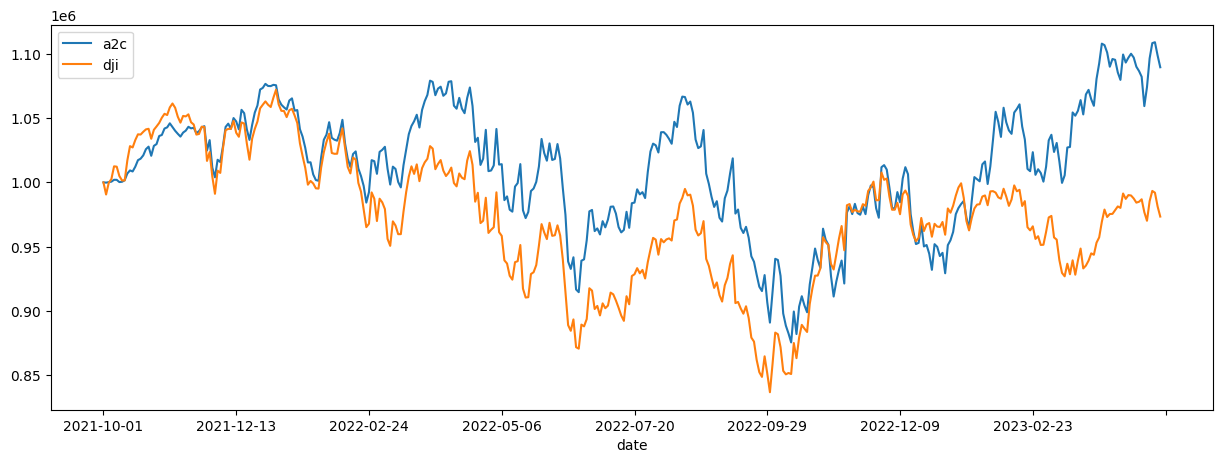

In [56]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

아래는 다우존스 지수. 일반적이 지수추종 ETF를 샀으면 개손해봤음

In [66]:
df_result_a2c.iloc[-1,0]

1089532.3469423954

In [72]:
print('A2C로 얻은 투자 수익률>>', round((df_result_a2c.iloc[-1,0]/df_result_a2c.iloc[0,0]-1)*100,2),'%')

A2C로 얻은 투자 수익률>> 8.95 %


In [89]:
df_daily_return = df_account_value_a2c
df_daily_return

,date,account_value
0,2021-10-01,1.000000e+06
1,2021-10-04,9.998138e+05
2,2021-10-05,1.000203e+06
3,2021-10-06,1.000564e+06
4,2021-10-07,1.002021e+06
...,...,...
394,2023-04-27,1.096471e+06
395,2023-04-28,1.108291e+06
396,2023-05-01,1.108994e+06
397,2023-05-02,1.098692e+06


In [74]:
df_actions_a2c

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2021-10-01,0,100,0,57,0,100,100,100,48
2021-10-04,0,100,0,57,0,100,100,100,48
2021-10-05,0,100,0,57,0,100,100,100,48
2021-10-06,0,100,0,57,0,100,100,100,48
2021-10-07,0,100,0,57,0,100,100,100,48
...,...,...,...,...,...,...,...,...,...
2023-04-26,0,0,0,0,75,0,-46,-100,0
2023-04-27,0,0,0,0,-47,0,0,93,0
2023-04-28,0,0,0,0,75,0,0,-100,0


전반적 포트폴리오 비중 확인 가능

In [87]:
total = [0,0,0,0,0,0,0,0,0]
for index, j in enumerate(df_actions_a2c.columns):
  for i in df_actions_a2c[j]:
    if i>0:
      total[index]+= i

print(total)

[3237, 9486, 706, 2112, 17895, 12475, 15912, 19521, 1105]


<Axes: xlabel='date'>

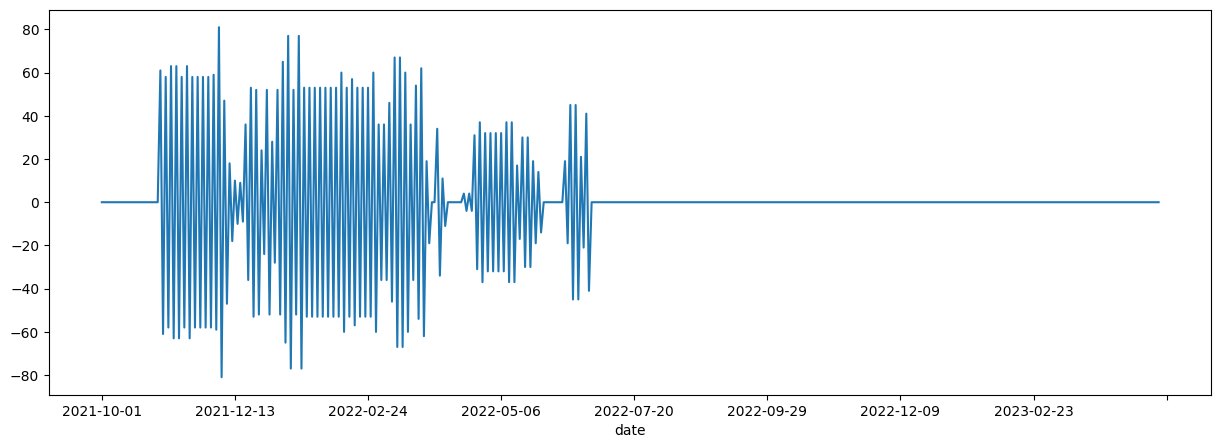

In [88]:
df_actions_a2c['XLB'].plot()

거래가 너무 많다. 아무래도 수수료 reward에 반영되지 않은듯 현실에 적용 불가능하지 않을까?

앞으로 해야할 일.

1. baseline parameter 바꿔가면서 최적값 찾기... <- (굳이 해야하나 의문 일단 내 컴으론 에바임)

2. prediction data를 삽입할 수 있는 방법 찾아보기

3. 수수료가 지금 책정이 아예 안됨. 이것도 같이 넣어줘야 <- 이 문제만 해결되면 진짜 쓸만한거같음.

4. potpolio 강화학습상에서는 알아서 되는데, 따로 추가 해야하는지 고민좀 해봐야 할듯.